# Równoważenia obciążenia przez alokację shardów

Inicjalizacja środowiska

In [1]:
import pprint
import operator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import itertools
%matplotlib notebook
pp = pprint.PrettyPrinter(indent=1, width=140)
sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = [7, 4]

Inicjalizacja wektora obciążeń poszczególnych shardów (F)

In [2]:
np.random.seed(23456789)

F_base = np.random.normal(loc=7, scale=1, size=(400, 100))
pp.pprint(F_base)
print(np.array(F_base).shape)

array([[7.66453587, 6.66192441, 5.3615201 , ..., 6.67318347, 6.75706923,
        6.30120981],
       [6.64067853, 7.08540122, 6.97698422, ..., 7.97566644, 5.15715268,
        8.13467868],
       [5.61516121, 7.86733846, 7.14924725, ..., 6.93862102, 6.51528925,
        6.64301763],
       ...,
       [6.04450384, 7.29914501, 6.03548309, ..., 6.06342221, 6.06106462,
        5.84151371],
       [6.97692326, 6.81407277, 5.89112885, ..., 4.71890367, 7.12459224,
        6.18594598],
       [6.93547839, 8.14002678, 7.16779923, ..., 4.93422969, 7.77593682,
        5.78302775]])
(400, 100)


Rozkład wartości

/usr/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


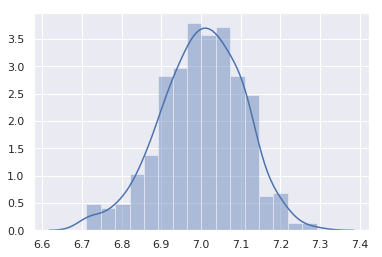

In [3]:
F_base_arr = np.array(F_base)
sns.distplot(np.apply_along_axis(lambda x: np.mean(x), 1, F_base_arr));

Wyznaczenie ilości węzłów chmury (n)

In [4]:
n = 20

Wyznaczenie sumarycznego wektora obciążenia całej chmury

In [5]:
wts = list(map(sum, zip(*F_base)))

Wyznaczenie względnego obciążenia przypadającego na jeden węzeł chmury

In [6]:
nwts = sum(list(wts))

Sortowanie względem modułu

In [7]:
F=sorted([x * n for x in F_base],key=sum, reverse=True)

Alokowanie wektorów shardów względem posortowanego obciążenia

In [8]:
N = [[0 for y in F[x]] for x in range(0, n)]
R1 = [[0 for y in F[x]] for x in range(0, n)]
R2 = [[0 for y in F[x]] for x in range(0, int(n/2))]
R4 = [[0 for y in F[x]] for x in range(0, int(n/4))]

for R1_index, shard in enumerate(F):
    #
    maxValue = None
    maxNodeIndex = None

    for index, node in enumerate(N):
        
        if(sum(node) >= nwts):
            continue
        abs1 = abs(distance.euclidean(wts , node))
        temp  = [node,shard]
        abs2 = abs(distance.euclidean(wts,  [sum(x) for x in zip(*temp)]))
        value = abs1-abs2
        
        if(maxValue is None or value > maxValue):
            maxValue=value
            maxNodeIndex=index
    
    # suma dwoch wektorow
    N[maxNodeIndex]=list(map(operator.add, N[maxNodeIndex], list(shard)))
    
    # przydzielanie shardow losowe
    R1[R1_index%n]=list(map(operator.add, R1[R1_index%n], F_base[R1_index]))
    
    # przydzielanie shardow losowe - replikacja podwojna
    R2[R1_index%int(n/2)]=list(map(operator.add, R2[R1_index%int(n/2)], F_base[R1_index]))
    
    # przydzielanie shardow losowe - replikacja poczwórna
    R4[R1_index%int(n/4)]=list(map(operator.add, R4[R1_index%int(n/4)], F_base[R1_index]))
    
#powrocenie do zmniejszonej o n 
N=[[x/n for x in f] for f in N]


Określenie średniej mocy chmury

In [9]:
power = 140

Wyznaczenie średniego obciążenia w czasie każdego węzła chmury(algorytm vs losowy przydział)

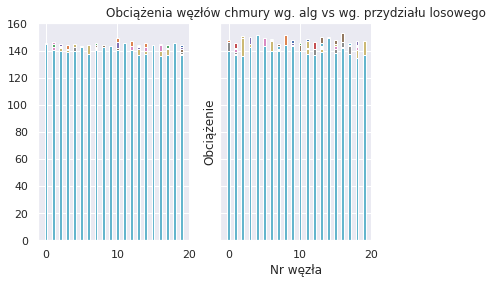

In [10]:
width = 0.4
Narray = np.transpose(np.array(N))
NR1array = np.transpose(np.array(R1))
NR2array = np.transpose(np.array(R2))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

plt.xlabel("Nr węzła")
plt.ylabel("Obciążenie")
plt.title("Obciążenia węzłów chmury wg. alg vs wg. przydziału losowego")

ind = np.arange(n)
for index, value in enumerate(N):
    ax1.bar(range(0,n ), list(Narray[index]), width)
    ax2.bar(range(0,n ), list(NR1array[index]), width)

plt.show()

Wyznaczenie średniego przeciążenia każdego węzła chmury

In [11]:
loadN = list()
for node in N:
    nodeLoad = 0
    for index, value in enumerate(node):
        load = value-power
        if(load > 0):
            if(index < len(node)-1):
                node[index+1] += load
            nodeLoad += load
        
    loadN.append(nodeLoad)

Wyznaczenie średniego przeciążenia każdego węzła dla losowego przydziału

In [12]:
loadR1 = list()
for node in R1:
    nodeLoad = 0
    for index, value in enumerate(node):
        load = value-power
        if(load > 0):
            if(index < len(node)-1):
                node[index+1] += load
            nodeLoad += load
        
    loadR1.append(nodeLoad)

Wyznaczenie średniego przeciążenia każdego węzła dla losowego przydziału - podwójnej replikacji

In [13]:
loadR2 = list()
for node in R2:
    nodeLoad = 0
    for index, value in enumerate(node):
        load = value-(power*2)
        if(load > 0):
            if(index < len(node)-1):
                node[index+1] += load
            nodeLoad += load
        
    loadR2.append(nodeLoad)

Wyznaczenie średniego przeciążenia każdego węzła dla losowego przydziału - poczwórna replikacji

In [14]:
loadR4 = list()
for node in R4:
    nodeLoad = 0
    for index, value in enumerate(node):
        load = value-(power*4)
        if(load > 0):
            if(index < len(node)-1):
                node[index+1] += load
            nodeLoad += load
        
    loadR4.append(nodeLoad)

Opóźnienia dla algorytmu, przydziału losowego oraz replikacji 2x i 4x

In [15]:
print("Alg : %.4f" % sum(loadN))
print("Rand: %.4f" % sum(loadR1))
print("Rep2: %.4f" % sum(loadR2))
print("Rep4: %.4f" % sum(loadR4))

Alg : 27507.0010
Rand: 44032.1850
Rep2: 32248.9717
Rep4: 23039.4307


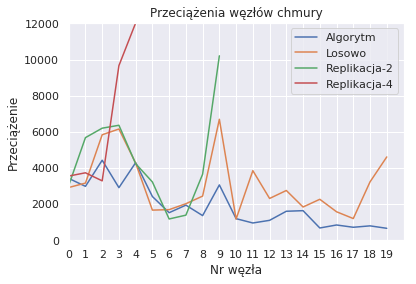

In [16]:
loadN_powerRelated = [x/(len(F_base[0]))*power for x in loadN]
plt.plot(loadN_powerRelated)

loadR1_powerRelated = [x/(len(F_base[0]))*power for x in loadR1]
plt.plot(loadR1_powerRelated)

loadR2_powerRelated = [x/(len(F_base[0]))*power for x in loadR2]
plt.plot(loadR2_powerRelated)

loadR4_powerRelated = [x/(len(F_base[0]))*power for x in loadR4]
plt.plot(loadR4_powerRelated)

plt.xlabel("Nr węzła")
plt.ylabel("Przeciążenie")
plt.axis([0, n, -5, max(itertools.chain(loadN, loadR1,loadR2,loadR4))/(len(F_base[0]))*power+5])
plt.xticks(range(0,n))
plt.title("Przeciążenia węzłów chmury")
plt.legend(["Algorytm", "Losowo","Replikacja-2","Replikacja-4"])
plt.show()